# Deutsch-Jozsa Algorithm

In this section, we first introduce the Deutsch-Jozsa problem,  and quantum algorithms to solve it. We then implement the quantum algorithm using Qiskit, and run it on a simulator and device.

## 1. Introduction <a id='introduction'></a>

The Deutsch-Jozsa algorithm, first introduced in Reference [1], was the first example of a quantum algorithm that performs better than the best classical algorithm. It showed that there can be advantages to using a quantum computer as a computational tool for a specific problem.

### 1.1 Deutsch-Jozsa Problem <a id='djproblem'> </a>

We are given a hidden Boolean function $f$, which takes as input a string of bits, and returns either $0$ or $1$, that is:

$$
f(\{x_0,x_1,x_2,...\}) \rightarrow 0 \textrm{ or } 1 \textrm{ , where } x_n \textrm{ is } 0 \textrm{ or } 1$$

The property of the given Boolean function is that it is guaranteed to either be balanced or constant. A constant function returns all $0$'s or all $1$'s for any input, while a balanced function returns $0$'s for exactly half of all inputs and $1$'s for the other half. Our task is to determine whether the given function is balanced or constant. 

Note that the Deutsch-Jozsa problem is an $n$-bit extension of the single bit Deutsch problem. 


### 1.3 Quantum Solution <a id='quantum-solution'> </a>

Using a quantum computer, we can solve this problem with 100% confidence after only one call to the function $f(x)$, provided we have the function $f$ implemented as a quantum oracle, which maps the state $\vert x\rangle \vert y\rangle $ to $ \vert x\rangle \vert y \oplus f(x)\rangle$, where $\oplus$ is addition modulo $2$. Below is the generic circuit for the Deutsch-Jozsa algorithm.

![image1](images/deutsch_steps.png)



## 2. Creating Quantum Oracles <a id='creating-quantum-oracles'> </a>

Let's see some different ways we can create a quantum oracle. 

For a balanced function, there are many different circuits we can create. One of the ways we can guarantee our circuit is balanced is by performing a CNOT for each qubit. For example:

![image2](images/deutsch_balanced1.svg)

In the image above, the top three qubits form the input register, and the bottom qubit is the output register. We can see which input states give which output in the table below:

| Input states that output 0 | Input States that output 1 |
|:--------------------------:|:--------------------------:|
|             000            |             001            |
|             011            |             100            |
|             101            |             010            |
|             110            |             111            |


We can change the results while keeping them balanced by wrapping selected controls in X-gates. For example, see the circuit and its results table below:

![other_balanced_circuit](images/deutsch_balanced2.svg)

| Input states that output 0 | Input states that output 1 |
|:--------------------------:|:--------------------------:|
|             001            |             000            |
|             010            |             011            |
|             100            |             101            |
|             111            |             110            |

For a constant function, it is simple:

$\qquad$ 1. if f(x) = 0, then apply the $I$ gate to the last qubit.  
$\qquad$ 2. if f(x) = 1, then apply the $X$ gate to the last qubit.

## 3. Qiskit Implementation <a id='implementation'></a>

We now implement the Deutsch-Jozsa algorithm for the example of a three-bit function, with both constant and balanced oracles. First let's do our imports:

In [1]:
# initialization
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

Next, we set the size of the input register for our oracle:

In [2]:
# set the length of the n-bit input string. 
n = 3

### 3.1 Constant Oracle <a id='const_oracle'></a>
Let's start by creating a constant oracle, in this case the input has no effect on the output so we just randomly set the output qubit to be 0 or 1:

In [3]:
# set the length of the n-bit input string. 
n = 3

const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw()

q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘

### 3.2 Balanced Oracle <a id='balanced_oracle'></a>

In [4]:
balanced_oracle = QuantumCircuit(n+1)

Next, we create a balanced oracle. As we saw in section above, we can create a balanced oracle by performing CNOTs with each input qubit as a control and the output bit as the target. We can vary the input states that give 0 or 1 by wrapping some of the controls in X-gates. Let's first choose a binary string of length `n` that dictates which controls to wrap:

In [5]:
b_str = "101"

Now we have this string, we can use it as a key to place our X-gates. For each qubit in our circuit, we place an X-gate if the corresponding digit in `b_str` is `1`, or do nothing if the digit is `0`.

In [6]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
balanced_oracle.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────

Next, we do our controlled-NOT gates, using each input qubit as a control, and the output qubit as a target:

In [7]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()
balanced_oracle.draw()

┌───┐ ░                 ░ 
q_0: ┤ X ├─░───■─────────────░─
     └───┘ ░   │             ░ 
q_1: ──────░───┼────■────────░─
     ┌───┐ ░   │    │        ░ 
q_2: ┤ X ├─░───┼────┼────■───░─
     └───┘ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ 
q_3: ──────░─┤ X ├┤ X ├┤ X ├─░─
           ░ └───┘└───┘└───┘ ░

Finally, we repeat the code from two cells up to finish wrapping the controls in X-gates:

In [8]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw()

┌───┐ ░                 ░ ┌───┐
q_0: ┤ X ├─░───■─────────────░─┤ X ├
     └───┘ ░   │             ░ └───┘
q_1: ──────░───┼────■────────░──────
     ┌───┐ ░   │    │        ░ ┌───┐
q_2: ┤ X ├─░───┼────┼────■───░─┤ X ├
     └───┘ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘
q_3: ──────░─┤ X ├┤ X ├┤ X ├─░──────
           ░ └───┘└───┘└───┘ ░

We have just created a balanced oracle! All that's left to do is see if the Deutsch-Jozsa algorithm can solve it.

### 3.3 The Full Algorithm <a id='full_alg'></a>

Let's now put everything together. This first step in the algorithm is to initialize the input qubits in the state $|{+}\rangle$ and the output qubit in the state $|{-}\rangle$:

In [20]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)
dj_circuit.draw()

┌───┐     
q_0: ┤ H ├─────
     ├───┤     
q_1: ┤ H ├─────
     ├───┤     
q_2: ┤ H ├─────
     ├───┤     
q_3: ┤ H ├─────
     ├───┤┌───┐
q_4: ┤ X ├┤ H ├
     └───┘└───┘
c: 4/══════════

Next, let's apply the oracle. Here we apply the `balanced_oracle` we created above:

In [21]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n) 

#Add a barrier
dj_circuit.barrier()

# Add oracle
dj_circuit.compose(balanced_oracle)
#dj_circuit += balanced_oracle
dj_circuit.draw()

┌───┐      ░ 
q_0: ┤ H ├──────░─
     ├───┤      ░ 
q_1: ┤ H ├──────░─
     ├───┤      ░ 
q_2: ┤ H ├──────░─
     ├───┤      ░ 
q_3: ┤ H ├──────░─
     ├───┤┌───┐ ░ 
q_4: ┤ X ├┤ H ├─░─
     └───┘└───┘ ░ 
c: 4/═════════════

Finally, we perform H-gates on the $n$-input qubits, and measure our input register:

In [11]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

#Add a barrier
dj_circuit.barrier()

# Add oracle
dj_circuit.compose(balanced_oracle)
#dj_circuit += balanced_oracle
#Add a barrier
dj_circuit.barrier()

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()

┌───┐      ░  ░ ┌───┐ ░ ┌─┐      
q_0: ┤ H ├──────░──░─┤ H ├─░─┤M├──────
     ├───┤      ░  ░ ├───┤ ░ └╥┘┌─┐   
q_1: ┤ H ├──────░──░─┤ H ├─░──╫─┤M├───
     ├───┤      ░  ░ ├───┤ ░  ║ └╥┘┌─┐
q_2: ┤ H ├──────░──░─┤ H ├─░──╫──╫─┤M├
     ├───┤┌───┐ ░  ░ └───┘ ░  ║  ║ └╥┘
q_3: ┤ X ├┤ H ├─░──░───────░──╫──╫──╫─
     └───┘└───┘ ░  ░       ░  ║  ║  ║ 
c: 3/═════════════════════════╩══╩══╩═
                              0  1  2

Let's see the output:

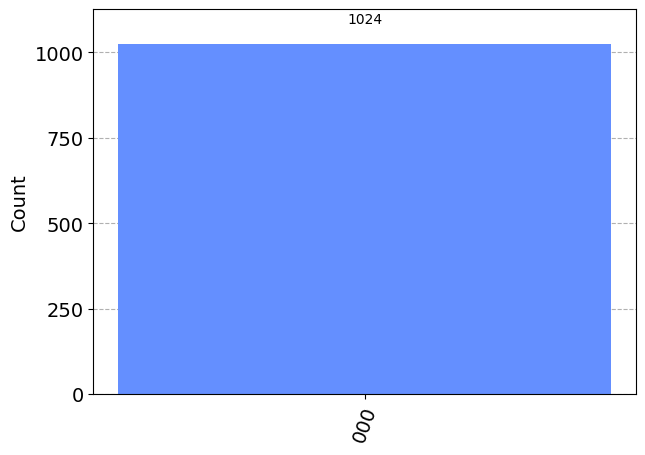

In [12]:
# use local simulator
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 1024
#qobj = assemble(dj_circuit, qasm_sim)
results = qasm_sim.run(dj_circuit, shots=shots).result()

answer = results.get_counts()

plot_histogram(answer)

We can see from the results above that we have a 0% chance of measuring `000`. This correctly predicts the function is balanced. 

### 3.4 Generalised Circuits <a id='general_circs'></a>

Below, we provide a generalised function that creates Deutsch-Jozsa oracles and turns them into quantum gates. It takes the `case`, (either `'balanced'` or '`constant`', and `n`, the size of the input register:

In [13]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

Let's also create a function that takes this oracle gate and performs the Deutsch-Jozsa algorithm on it:

In [14]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

Finally, let's use these functions to play around with the algorithm:

In [15]:
n = 4
oracle_gate = dj_oracle('constant', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

┌───┐     ┌─────────┐┌───┐┌─┐         
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├─────────
     ├───┤     │         │├───┤└╥┘┌─┐      
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├──────
     ├───┤     │         │├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├─────┤2 Oracle ├┤ H ├─╫──╫─┤M├───
     ├───┤     │         │├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─────┤3        ├┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├┤4        ├──────╫──╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║  ║ 
c: 4/═══════════════════════════╩══╩══╩══╩═
                                0  1  2  3

And see the results of running this circuit:

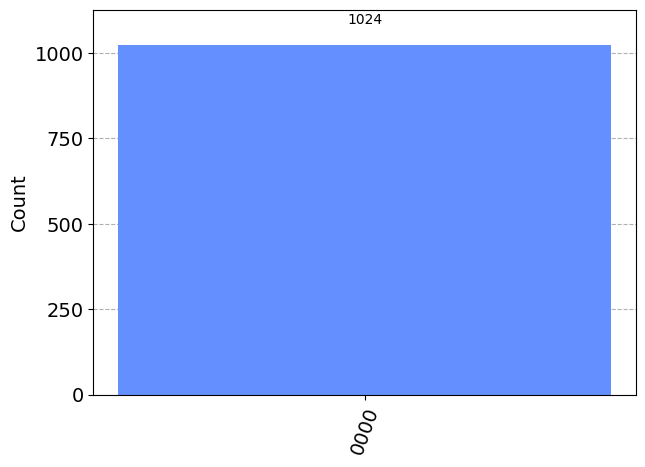

In [16]:
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(transpiled_dj_circuit).result()
answer = results.get_counts()
plot_histogram(answer)

## 7. References <a id='references'></a>

1. David Deutsch and Richard Jozsa (1992). "Rapid solutions of problems by quantum computation". Proceedings of the Royal Society of London A. 439: 553–558.  [doi:10.1098/rspa.1992.0167](https://doi.org/10.1098%2Frspa.1992.0167).
2. R. Cleve; A. Ekert; C. Macchiavello; M. Mosca (1998). "Quantum algorithms revisited". Proceedings of the Royal Society of London A. 454: 339–354. [doi:10.1098/rspa.1998.0164](https://doi.org/10.1098%2Frspa.1998.0164).

In [17]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.23.1', 'qiskit-aer': '0.11.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.0', 'qiskit': '0.41.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}